<a href="https://colab.research.google.com/github/jodejetalo99/Introduccion-al-Aprendizaje-Profundo/blob/main/Proyecto/Proyecto_IAPP_JJTL_M11_FINAL_ENTREGABLE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Proyecto: Conteo y clasificación por audio (Basado en redes convolucionales 1D y 2D)

## Integrantes:
- Martiñón Luna Jonathan José
- Tapia López José de Jesús

## Licenciatura en Ciencia de Datos
## Universidad Nacional Autónoma de México 



---

## Bibliotecas

---


In [1]:
# Colab
! pip install torchinfo
try:
    import torchaudio
except:
    ! pip install torchaudio

     |████████████████████████████████| 1.9MB 7.5MB/s 


In [2]:
# funciones aleatorias
import random
# arreglos multidimensionales
import numpy as np
from google.colab import drive
import pandas as pd
# Graficos
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
# tomar n elementos de una secuencia
from itertools import islice as take

# Audios
from scipy.io import wavfile
import librosa
import librosa.display
import IPython as ip

# reproductor
import IPython as ip
# gráficas
import matplotlib.pyplot as plt
# arreglos multidimensionales
import numpy as np

# redes neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# redes audio
import torchaudio
import torchaudio.transforms as T
# redes visión
import torchvision.models as tvm

# redes neuronales
from torch.utils.data import DataLoader
# inspección de arquitectura
from torchinfo import summary

# barras de progreso
from tqdm.auto import trange

---

## Auxiliares

---


In [3]:
# directorio de datos
DATA_DIR = 'Data'

# tamaño del lote
BATCH_SIZE = 32

# filas y columnas de la regilla de imágenes
ROWS, COLS = 4, 8

# parámetros de audio
SECS = 1
SAMPLE_RATE = 16000

# clases del conjunto de dato
CLASES = {0:'1 hablante', 1:'2 hablantes', 2:'3 hablantes'}

def display_grid(xs, titles, rows, cols, figsize=(16, 10), SAMPLE_RATE=16000):
    """Desplegamos ejemplos en una malla."""
    fig, ax = plt.subplots(rows, cols, figsize=figsize)
    i = 0
    for r in range(rows):
        for c in range(cols):
            librosa.display.waveplot(xs[i].squeeze().numpy(), sr=SAMPLE_RATE, ax=ax[r,c])
            ax[r, c].set_title(titles[i])
            ax[r, c].set_xticklabels([])
            ax[r, c].set_yticklabels([])
            ax[r, c].set_xlabel('')
            i += 1
    fig.tight_layout()
    plt.show()

# semilla para reproducibilidad
def set_seed(seed=17):
    """Initializes pseudo-random number generators."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    
# reproducibilidad
set_seed()

---

## Descarga de datos

---


Montamos drive, para realizar la extracción de los datos a utilizar.

In [4]:
drive.mount('/content/drive/')

Mounted at /content/drive/


Movemos los archivos a una carpeta específica (`./Data`), para no tener que buscarlos o ingresar la dirección completa

In [5]:
!mkdir "./Data"
!cp "drive/MyDrive/Intro_Ap_Prof/Proyecto/Validacion.csv" "Data"
!cp "drive/MyDrive/Intro_Ap_Prof/Proyecto/Entrenamiento.csv" "Data"
!cp "drive/MyDrive/Intro_Ap_Prof/Proyecto/Prueba.csv" "Data"

In [6]:
!unzip -q "drive/My Drive/Intro_Ap_Prof/Proyecto/Audios_Prueba.zip" -d "./Data"
!unzip -q "drive/My Drive/Intro_Ap_Prof/Proyecto/Audios_Validacion.zip" -d "./Data"
!unzip -q "drive/My Drive/Intro_Ap_Prof/Proyecto/Audio_Entrenamiento.zip" -d "./Data"

Una vez que ya contamos con los archivos necesarios, procedemos a desmontar nuestro drive.

In [7]:
drive.flush_and_unmount()

In [8]:
! ls -R {'Data'} | head -20

Data:
Entrenamiento
Entrenamiento.csv
Prueba
Prueba.csv
Validacion
Validacion.csv

Data/Entrenamiento:
Audio_Train0.wav
Audio_Train10000.wav
Audio_Train10001.wav
Audio_Train10002.wav
Audio_Train10003.wav
Audio_Train10004.wav
Audio_Train10005.wav
Audio_Train10006.wav
Audio_Train10007.wav
Audio_Train10008.wav
Audio_Train10009.wav


## Lectura de datos

In [9]:
entrenamiento_df = pd.read_csv("./Data/Entrenamiento.csv")
validacion_df = pd.read_csv("./Data/Validacion.csv")
prueba_df = pd.read_csv("./Data/Prueba.csv")

### Datasets

In [10]:
print(f"Contamos con {str(entrenamiento_df.shape[0])[:3]},{str(entrenamiento_df.shape[0])[3:]} datos de Entrenamiento.")
# cambiamos las etiquetas para que empiecen desde 0
# 0: 1 hablante
# 1: 2 hablantes
# 2: 3 hablantes
entrenamiento_df['Speakers_Class'] = entrenamiento_df['Speakers'] - 1
entrenamiento_df.head()


Contamos con 100,000 datos de Entrenamiento.


,Waveform,Speakers,Speakers_Sex,F,M,Speakers_Class
0,[-0.00354004 -0.00354004 -0.00372314 ... 0.00...,1,F,1,0,0
1,[-0.05560303 -0.03948975 -0.01425171 ... 0.06...,1,M,0,1,0
2,[0.08041382 0.10652161 0.13059998 ... 0.017501...,2,FF,2,0,1
3,[0.00216675 0.00177002 0.00131226 ... 0.022705...,1,M,0,1,0
4,[ 0.0064799 0.00262451 0.00343831 ... -0.00...,3,FFF,3,0,2


In [11]:
print(f"Contamos con {str(validacion_df.shape[0])[:2]},{str(validacion_df.shape[0])[2:]} datos de Validación.")
# cambiamos las etiquetas para que empiecen desde 0
# 0: 1 hablante
# 1: 2 hablantes
# 2: 3 hablantes
validacion_df['Speakers_Class'] = validacion_df['Speakers'] - 1

validacion_df.head()

Contamos con 10,000 datos de Validación.


,Waveform,Speakers,Speakers_Sex,F,M,Speakers_Class
0,[ 0.0045166 0.00930786 -0.00366211 ... 0.02...,1,M,0,1,0
1,[ 0.02026367 0.02442932 0.02787781 ... -0.00...,2,MM,0,2,1
2,[-0.03646851 -0.03983561 -0.04340617 ... -0.03...,3,MMF,1,2,2
3,[ 0.02868652 0.0123291 0.00295003 ... -0.02...,3,MMM,0,3,2
4,[0.01849365 0.02142334 0.01538086 ... 0.020345...,3,MMM,0,3,2


In [12]:
print(f"Contamos con {str(prueba_df.shape[0])[:2]},{str(prueba_df.shape[0])[2:]} datos de prueba.")
# cambiamos las etiquetas para que empiecen desde 0
# 0: 1 hablante
# 1: 2 hablantes
# 2: 3 hablantes
prueba_df['Speakers_Class'] = prueba_df['Speakers'] - 1
prueba_df.head()

Contamos con 10,000 datos de prueba.


,Waveform,Speakers,Speakers_Sex,F,M,Speakers_Class
0,[ 0.00117493 0.00216675 0.0037384 ... -0.01...,2,MF,1,1,1
1,[-3.0517578e-05 1.8310547e-04 2.5939941e-04 ...,2,MF,1,1,1
2,[-0.03262329 -0.03387451 -0.03366089 ... 0.00...,1,M,0,1,0
3,[-0.03912354 -0.02819824 -0.02289836 ... -0.10...,3,MMM,0,3,2
4,[ 0.00628662 0.01490784 0.01811218 ... -0.01...,2,MF,1,1,1


### Conjunto de datos

In [13]:
class Audios:

    def __init__(self, subset, dataframe, cantidad_datos):
        #super().__init__()
        # Almacenamos la ruta acorte al conjunto de datos
        self.subset = 'Data/'+subset
        # Almacenamos la cantidad de datos
        self.cantidad_datos = cantidad_datos
        
        # En caso de que nuestro conjunto sea  Entrenamiento ajustamos la ruta de lectura
        if self.subset == 'Data/Entrenamiento':
          self.read = self.subset + '/Audio_Train'
          
        # En caso de que nuestro conjunto sea Validación ajustamos la ruta de lectura
        elif self.subset == 'Data/Validacion':
          self.read = self.subset + '/Audio_Validation'
        
        # En otro caso asumiremos que nuestro conjunto será Prueba, por lo que ajustamos la ruta de lectura
        else:
          self.read = self.subset+'/Audio_Test'

        # Una vez obtenida la ruta, procedemos con la lectura de los audios
        self.audios = [wavfile.read(self.read+str(i)+'.wav')[1].reshape(1,-1) for i in range(self.cantidad_datos)]
        
        # leemos el df que contiene a los metadatos
        self.df = dataframe

        # guardamos nuestra clase correspondiente al numero de hablantes como lista de enteros
        self.speakers_class = self.df['Speakers_Class'].tolist()

    def __getitem__(self, i):
        # cargamos el audio
        audio_i = self.audios[i]
        # cargamos sus metadatos
        # guardamos numero de hablantes como int
        speakers_class_i = self.speakers_class[i]
        # sample_rate
        return audio_i, speakers_class_i

    def __len__(self):
        # regresamos numeros de ejemplos
        return len(self.audios)


 ### Cargador de datos

In [14]:
def build_dl(subset, cantidad_datos, dataframe, BATCH_SIZE=32, shuffle=False):

   # creamos un Dataset
    ds = Audios(
        subset, #subconjunto de datos
        dataframe,
        cantidad_datos, # cantidad de datos del subconjunto
        )

    # creamos un DataLoader
    dl = DataLoader(
        # conjunto
        ds,
        # tamaño del lote
        batch_size=BATCH_SIZE,
        # barajear
        shuffle=shuffle,
    )
    return dl

#### Entrenamiento

/usr/local/lib/python3.7/dist-packages/torch/utils/data/_utils/collate.py:63: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return default_collate([torch.as_tensor(b) for b in batch])


x shape=torch.Size([32, 1, 16000]) dtype=torch.float32
y shape=torch.Size([32]) dtype=torch.int64


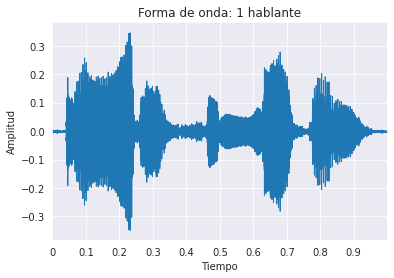

In [15]:
trn_dl = build_dl(subset='Entrenamiento', dataframe = entrenamiento_df, cantidad_datos=100000)

# desplegamos un lote de audios
x, y = next(iter(trn_dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')

# inspeccionemos un ejemplo
waveform = x[0].squeeze().numpy()
label = CLASES[y[0].item()]

# grafiquemos forma de onda
librosa.display.waveplot(waveform, sr=SAMPLE_RATE)
plt.title(f'Forma de onda: {label}')
plt.xlabel('Tiempo')
plt.ylabel('Amplitud')
plt.show()

# reproductor
ip.display.Audio(waveform, rate=SAMPLE_RATE)

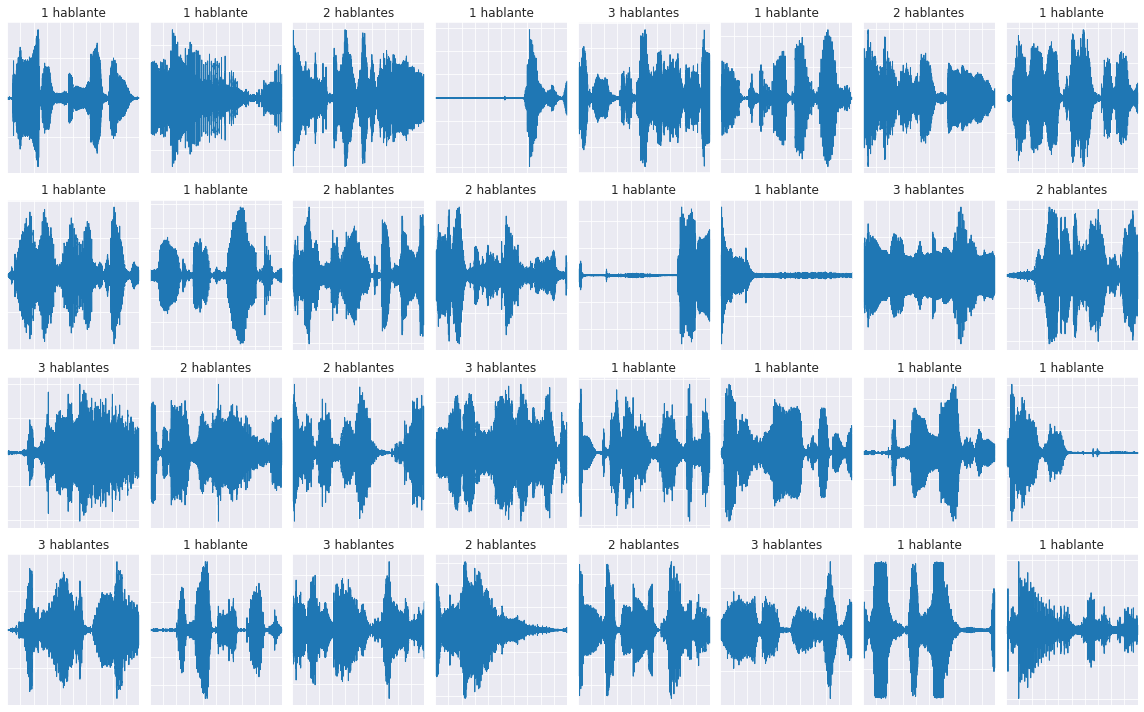

In [16]:
titles = [CLASES[i.item()] for i in y]
# desplegamos un lote de audios
display_grid(x, titles, ROWS, COLS)

#### Validación

x shape=torch.Size([32, 1, 16000]) dtype=torch.float32
y shape=torch.Size([32]) dtype=torch.int64


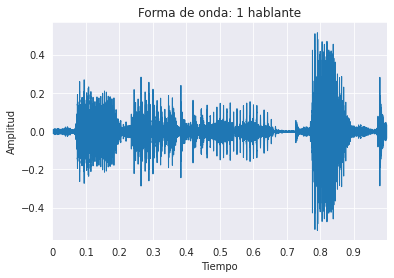

In [17]:
val_dl = build_dl(subset='Validacion', dataframe = validacion_df,cantidad_datos=10000)

# desplegamos un lote de audios
x, y = next(iter(val_dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')

# inspeccionemos un ejemplo
waveform = x[0].squeeze().numpy()
label = CLASES[y[0].item()]

# grafiquemos forma de onda
librosa.display.waveplot(waveform, sr=SAMPLE_RATE)
plt.title(f'Forma de onda: {label}')
plt.xlabel('Tiempo')
plt.ylabel('Amplitud')
plt.show()

# reproductor
ip.display.Audio(waveform, rate=SAMPLE_RATE)

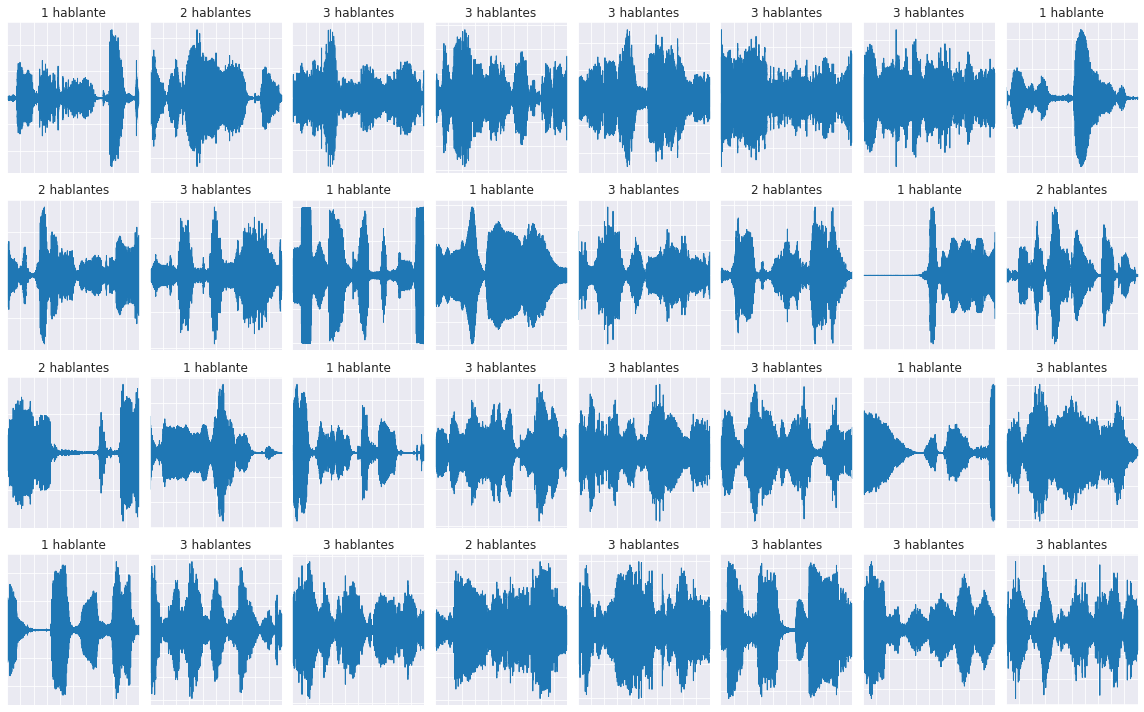

In [18]:
titles = [CLASES[i.item()] for i in y]
# desplegamos un lote de audios
display_grid(x, titles, ROWS, COLS)

# Ciclo de entrenamiento



In [19]:
def train_epoch(dl, model, opt):

    # por cada lote
    for x, y_true, *_ in dl:

        # computamos logits
        y_lgts = model(x)

        # computamos la pérdida
        loss = F.cross_entropy(y_lgts, y_true)

        # vaciamos los gradientes
        opt.zero_grad()

        # retropropagamos
        loss.backward()

        # actualizamos parámetros
        opt.step()


def eval_epoch(dl, model, num_batches=None):

    # evitamos que se registren las operaciones 
    # en la gráfica de cómputo
    with torch.no_grad():

        # historiales
        losses, accs = [], []

        # validación de la época con num_batches
        # si num_batches==None, se usan todos los lotes
        for x, y_true, *_ in take(dl, num_batches):

            # computamos los logits
            y_lgts = model(x)

            # computamos los puntajes
            y_prob = F.softmax(y_lgts, 1)

            # computamos la clases
            y_pred = torch.argmax(y_prob, 1)

            # computamos la pérdida
            loss = F.cross_entropy(y_lgts, y_true)

            # computamos la exactitud
            acc = (y_true == y_pred).type(torch.float32).mean()

            # guardamos históricos
            losses.append(loss.item())
            accs.append(acc.item())

        # promediamos
        loss = np.mean(losses) * 100
        acc = np.mean(accs) * 100

        return loss, acc
        
        
def train(model, trn_dl, tst_dl, lr=1e-4, epochs=20,
          trn_batches=None, tst_batches=None):

    # historiales
    loss_hist, acc_hist = [], []
    
    # optimizador
    opt = optim.Adam(model.parameters(), lr=lr)

    # ciclo de entrenamiento
    for epoch in trange(epochs):

        # modelo en modo de entrenamiento
        model.train()
        # entrenamos la época
        train_epoch(trn_dl, model, opt)

        # modelo en modo de evaluación
        model.eval()
        # evaluamos la época en entrenamiento
        trn_loss, trn_acc = eval_epoch(trn_dl, model, trn_batches)
        # evaluamos la época en prueba
        tst_loss, tst_acc = eval_epoch(tst_dl, model, tst_batches)

        # guardamos historial
        loss_hist.append([trn_loss, tst_loss])
        acc_hist.append([trn_acc, tst_acc])

        # imprimimos progreso
        print(f'E{epoch:02} '
              f'loss=[{trn_loss:6.2f},{tst_loss:6.2f}] '
              f'acc=[{trn_acc:5.2f},{tst_acc:5.2f}]')

    return loss_hist, acc_hist

# Arquitectura



## M11


In [20]:
class M11(nn.Module):
    def __init__(self,  n_input=1, n_output=3, stride=16, n_channel=32):
        super().__init__()
        self.cnn = nn.Sequential(
            # 1 - 1
            nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride),
            nn.BatchNorm1d(n_channel),
            nn.ReLU(),
            nn.MaxPool1d(4),

            # 2.1 - 2
            nn.Conv1d(n_channel, n_channel, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(n_channel),
            nn.ReLU(),
            # 2.2 -3
            nn.Conv1d(n_channel, n_channel, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(n_channel),
            nn.ReLU(),
            nn.MaxPool1d(4),

            # 3.1 - 4
            nn.Conv1d(n_channel, 2*n_channel, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(2*n_channel),
            nn.ReLU(),
            # 3.2 - 5
            nn.Conv1d(2*n_channel, 2*n_channel, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(2*n_channel),
            nn.ReLU(),
            nn.MaxPool1d(4),

             # 4.1 - 6
            nn.Conv1d(2*n_channel, 4*n_channel, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(4*n_channel),
            nn.ReLU(),
            # 4.2 - 7
            nn.Conv1d(4*n_channel, 4*n_channel, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(4*n_channel),
            nn.ReLU(),
            # 4.3 - 8
            nn.Conv1d(4*n_channel, 4*n_channel, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(4*n_channel),
            nn.ReLU(),
            nn.MaxPool1d(4),

            # 5.1 - 9
            nn.Conv1d(4*n_channel, 8*n_channel, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(8*n_channel),
            nn.ReLU(),
            # 5.2 - 10
            nn.Conv1d(8*n_channel, 8*n_channel, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(8*n_channel),
            nn.ReLU(),
        )

        self.pool = nn.AdaptiveAvgPool1d(1)
        self.flat = nn.Flatten()
        self.fc = nn.Linear(8*n_channel, n_output)

    def forward(self, x):
        x = self.cnn(x)
        x = self.pool(x)
        x = self.flat(x)
        x = self.fc(x)
        return x


def build_m11():
  return M11()

m11 = build_m11()
m11

M11(
  (cnn): Sequential(
    (0): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (8): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (11): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (12): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (15): BatchNorm1d(64, eps=1e-05, momentum=0.1

In [21]:
x = torch.zeros(1, 1, 16000)
y = m11(x)
print(f'{x.shape} => {y.shape}')

torch.Size([1, 1, 16000]) => torch.Size([1, 3])


In [22]:
summary(m11, (1, 1, 16000), verbose=0,
        col_names=['input_size', 'output_size', 'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
M11                                      --                        --                        --
├─Sequential: 1-1                        [1, 1, 16000]             [1, 256, 3]               --
│    └─Conv1d: 2-1                       [1, 1, 16000]             [1, 32, 996]              2,592
│    └─BatchNorm1d: 2-2                  [1, 32, 996]              [1, 32, 996]              64
│    └─ReLU: 2-3                         [1, 32, 996]              [1, 32, 996]              --
│    └─MaxPool1d: 2-4                    [1, 32, 996]              [1, 32, 249]              --
│    └─Conv1d: 2-5                       [1, 32, 249]              [1, 32, 249]              3,104
│    └─BatchNorm1d: 2-6                  [1, 32, 249]              [1, 32, 249]              64
│    └─ReLU: 2-7                         [1, 32, 249]              [1, 32, 249]              --
│    └─Conv1d: 2-8           

### Entrenamiento

Ahora sí, usamos esta arquitectura para entrenar este modelo 

In [24]:
epocas = 10
model = build_m11()
loss_hist, acc_hist = train(model, trn_dl, val_dl, lr = 0.0001, epochs=epocas)

E00 loss=[ 52.48, 57.69] acc=[76.80,73.91]
E01 loss=[ 46.34, 53.92] acc=[79.68,75.48]
E02 loss=[ 43.34, 52.15] acc=[80.93,76.55]
E03 loss=[ 41.04, 54.56] acc=[82.07,76.12]
E04 loss=[ 41.83, 60.56] acc=[81.82,75.13]
E05 loss=[ 41.95, 67.50] acc=[82.08,73.72]
E06 loss=[ 36.69, 72.07] acc=[84.68,74.66]
E07 loss=[ 32.21, 79.58] acc=[86.60,74.38]
E08 loss=[ 36.40, 85.12] acc=[85.44,74.12]
E09 loss=[ 34.62, 90.17] acc=[86.32,73.67]



#### Gráficas de pérdidas y exactitud

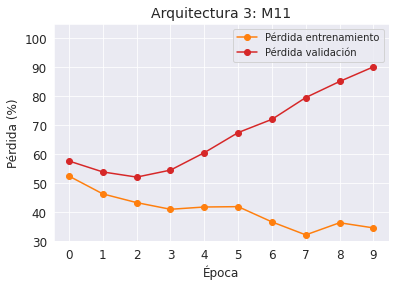

In [30]:
trn_loss, val_loss = zip(*loss_hist)
plt.plot(trn_loss, '-o',color='tab:orange', label='Pérdida entrenamiento')
plt.plot(val_loss, '-o',color='tab:red', label='Pérdida validación')
plt.legend(loc='upper right')
plt.xlabel('Época', fontsize=12)
plt.ylabel('Pérdida (%)',fontsize=12)
plt.xticks(np.arange(0,epocas), np.arange(0,epocas), fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(30,105)
plt.title('Arquitectura 3: M11', fontsize=14)
plt.show()

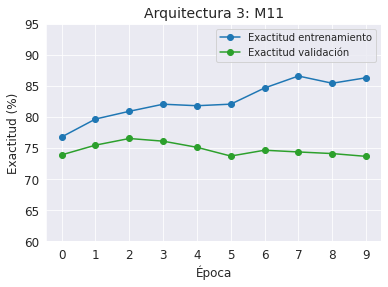

In [31]:
trn_loss, val_loss = zip(*acc_hist)
plt.plot(trn_loss, '-o', color='tab:blue', label='Exactitud entrenamiento')
plt.plot(val_loss,'-o', color='tab:green', label='Exactitud validación')
plt.legend(loc='upper right')
plt.xlabel('Época', fontsize=12)
plt.ylabel('Exactitud (%)',fontsize=12)
plt.xticks(np.arange(0,epocas), np.arange(0,epocas), fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(60,95)
plt.title('Arquitectura 3: M11', fontsize=14)
plt.show()

#### Evaluación

In [32]:
# cargamos los datos de prueba
tst_dl = build_dl(subset='Prueba', dataframe = prueba_df, cantidad_datos=10000)

In [33]:
# evaluamos en entrenamiento
trn_loss, trn_acc = eval_epoch(trn_dl, model)
# evaluamos en prueba
tst_loss, tst_acc = eval_epoch(tst_dl, model)
print(f'loss=[{trn_loss:6.2f},{tst_loss:6.2f}] '
      f'acc=[{trn_acc:5.2f},{tst_acc:5.2f}]')

loss=[ 34.62, 87.08] acc=[86.32,73.78]


#### Inferencia

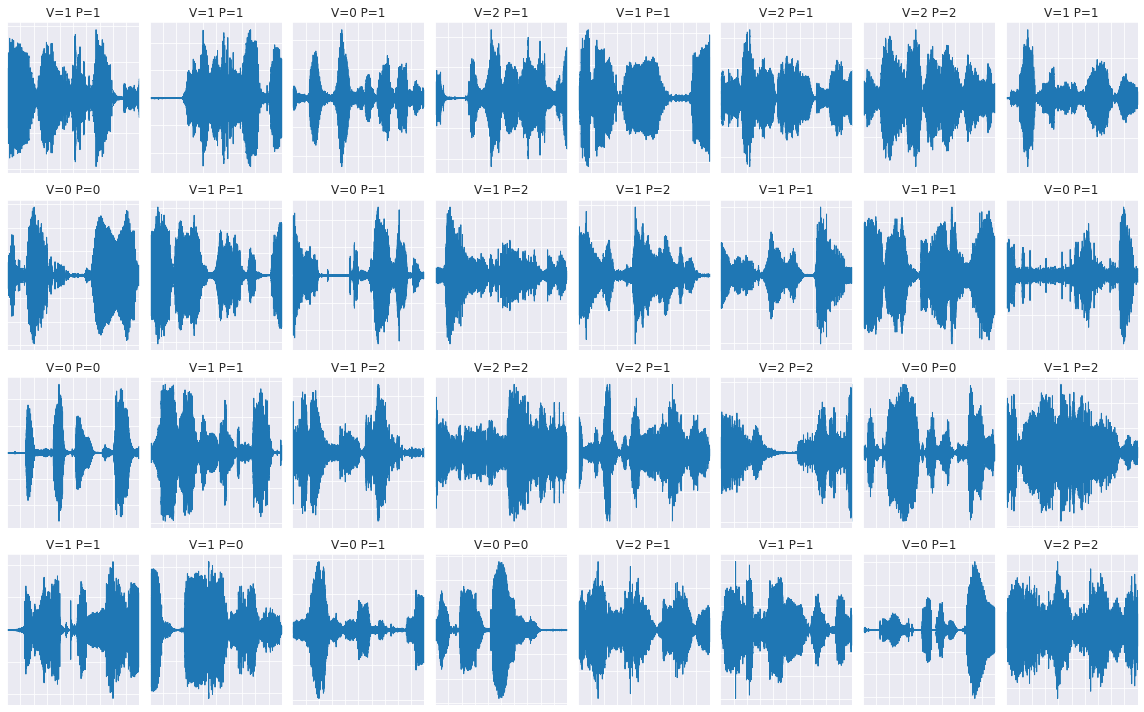

In [34]:
# inferencia

with torch.no_grad(): 
    x, y_true = next(iter(tst_dl))
    y_lgts = model(x)
    y_prob = F.softmax(y_lgts, 1)
    y_pred = torch.argmax(y_prob, 1) 
    titles = [f'V={t} P={p}' for t, p in zip(y_true, y_pred)]
    display_grid(x, titles, ROWS, COLS)   